# Импорт зависимостей и загрузка датасета

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [2]:
ds = pd.read_csv('Energy_and_Water_Data_Disclosure.csv') # https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml
print('Размер загруженного датасета: {}'.format(ds.shape))

Размер загруженного датасета: (11746, 60)


# Анализ и препроцессинг данных

Для ускорения вычислений создадим подвыборку из 2000 случайных элементов из исходного датасета и продолжим работать только с ними:

In [3]:
n_rand = np.random.randint(0, len(ds), 2000) # выберем 2000 случайных элементов из датасета
ds = ds.iloc[n_rand]

Начнем как обычно с подготовки данных как было показано в разделе 6.1:

In [4]:
ds.head(3) # посмотрим на первые 3 строчки датасета

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
5128,5974,3513155,"GVS Properties II, LLC/600W164St",Not Applicable: Standalone Property,Not Applicable: Standalone Property,1021370141,1021370141,1063371,600 West 164 Street,aka/ 3915 Broadway,...,203.1,04/28/2017 03:57:40 PM,Yes,In Compliance,40.838240,-73.941837,12.0,7.0,245.0,Washington Heights South ...
595,645,2657266,Millenium Hilton,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1000800004,1000800004,1075702,55 Church street,Not Available,...,263.1,03/26/2017 03:36:00 PM,No,In Compliance,40.711453,-74.010504,1.0,1.0,13.0,Battery Park City-Lower Manhattan ...
9533,11938,5803913,(7588) - Oceana Condo 50,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3087207511,3-08720-7511,3423914,50 Oceana Drive West,Not Available,...,127.8,04/04/2017 03:58:21 PM,Yes,In Compliance,40.577273,-73.958991,13.0,48.0,61002.0,Brighton Beach ...


In [5]:
ds = ds.drop(['Order', 'Property Id', 'Parent Property Id'], axis=1) #  выбросим признаки, т.к. это просто счетчики

В датасете много значений  "Not Available", заменим их на Nan:

In [6]:
ds = ds.replace('Not Available', np.nan)

In [7]:
ds.dtypes.value_counts() # кол-во признаков разных типов в датасете - 47 категориальных и 10 численных

object     47
float64     6
int64       4
dtype: int64

Кажется, что кол-во численных признаков должно быть больше, возможно они записаны как строковые переменные - проверим это:

In [8]:
for col in ds.columns: 
    if ds[col].dtype == 'O': # если колонка типа object
        try:
            ds[col] = ds[col].astype(float) # преобразуем в формат float
        except:
            pass

In [9]:
ds.dtypes.value_counts() # теперь кол-во категориальных равно 22, а числовых - 35

float64    31
object     22
int64       4
dtype: int64

Выбросим признаки, в которых отсутствуют больше 60 процентов данных:

In [10]:
missed_ratio = (ds.isna().sum()/len(ds)*100).sort_values(ascending=False) # процент пропущенных значений в каждом признаке
ds = ds.drop(missed_ratio[missed_ratio>60].index, axis=1)

Заполним пропуски в численных данных медианными значениями, а пропуски в категориальных данных - модальными:

In [19]:
y = ds.pop('Site EUI (kBtu/ft²)')

num_columns = ds.select_dtypes(exclude='O').columns # численные признаки в датасете
cat_columns = ds.select_dtypes(include='O').columns # категориальные признаки в датасете

ds[num_columns] = ds[num_columns].fillna(ds[num_columns].median()) # заполним пропуски медианными значениями
ds[cat_columns] = ds[cat_columns].fillna(ds[cat_columns].mode(axis=0).iloc[0]) # заполним пропуски модальными значениями

In [20]:
print('Кол-во пропущенных значения в датасете: {}'.format(ds.isna().sum().sum()))

Кол-во пропущенных значения в датасете: 0


In [23]:
ds_num = ds[num_columns] # рассматриваем только численные признаки

In [24]:
ds_num.head()

,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),...,Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
5128,58845.0,58845.0,1920,1,100,3.0,81.95,6.8,0.5,129.4,...,129.3,58845,4437.30,75.41,203.1,40.838240,-73.941837,12.0,7.0,245.0
595,383166.0,358200.0,1992,1,100,25.0,196.40,7.0,1.2,264.1,...,2011.1,358200,4668.55,44.82,263.1,40.711453,-74.010504,1.0,1.0,13.0
9533,126438.0,112048.0,2013,1,95,57.0,69.20,8.4,0.4,132.3,...,293.1,112048,4668.55,44.82,127.8,40.577273,-73.958991,13.0,48.0,61002.0
3871,194198.0,200024.0,1963,1,100,33.0,52.70,8.3,0.2,114.8,...,541.9,200024,4668.55,44.82,114.6,40.764838,-73.962745,8.0,4.0,118.0
5166,68240.0,56845.0,1920,1,100,65.0,81.95,6.0,0.1,129.4,...,113.4,58245,4162.20,71.46,154.5,40.845159,-73.940591,12.0,10.0,253.0


In [26]:
x_train, x_test, y_train, y_test = train_test_split(ds_num, y, test_size=0.2)

In [36]:
scl = StandardScaler()
x_train_scl = scl.fit_transform(x_train)
x_test_scl = scl.transform(x_test)

# Модель

In [41]:
def make_model(activation):
    input_ = keras.layers.Input(shape=(x_train.shape[1],)) # входной слой
    x = keras.layers.Dense(100, activation=activation)(input_) # полносвязный слой
    x = keras.layers.Dense(50, activation=activation)(x) # полносвязный слой
    x = keras.layers.Dense(20, activation=activation)(x) # полносвязный слой
    output_ = keras.layers.Dense(1)(x) # выходной слой

    model = keras.models.Model(input_, output_) # определем въод и выход моедли

    model.compile(loss = 'mse', # определяем метрики и алгоритм оптимизации
                  optimizer = 'adam',
                  metrics = ['mae']
                 )
    return model

In [42]:
leaky_relu = keras.layers.LeakyReLU(alpha=0.01) 

activations = ['relu', 'tanh', 'sigmoid', leaky_relu, 'elu'] # список функций активации

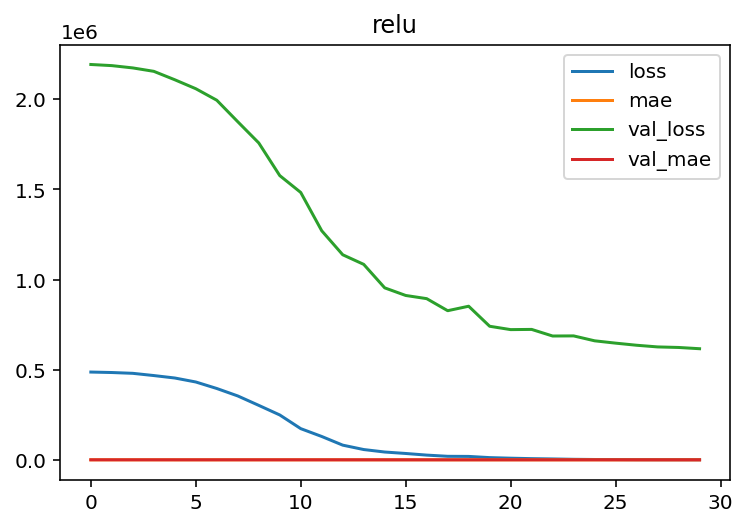

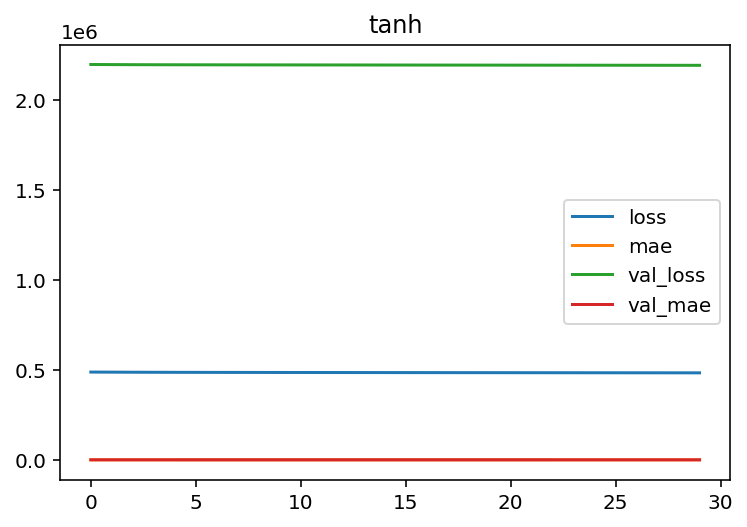

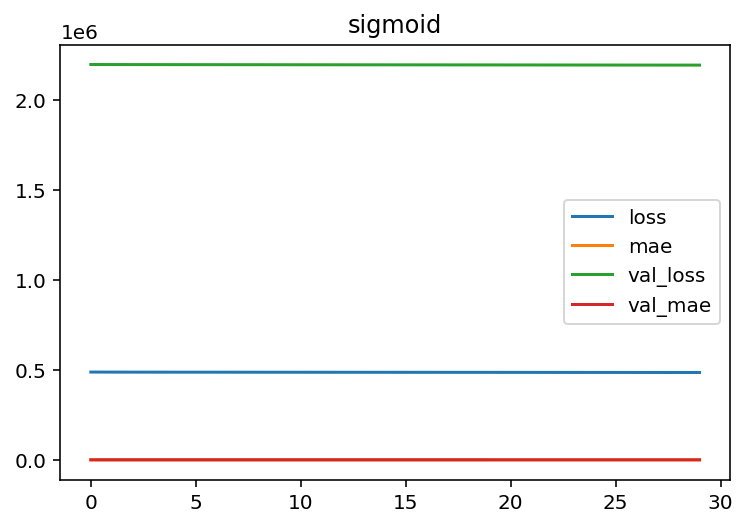

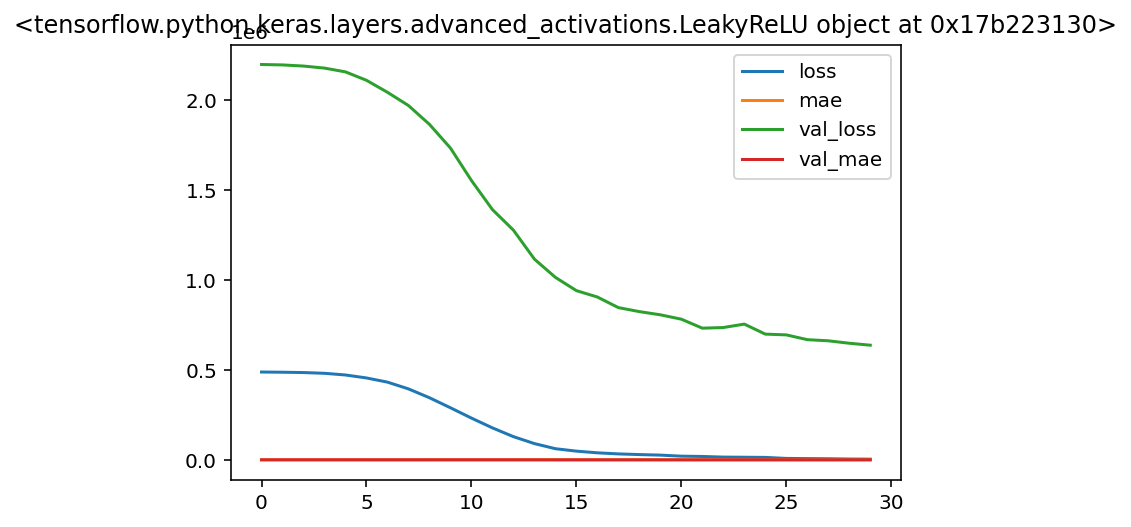

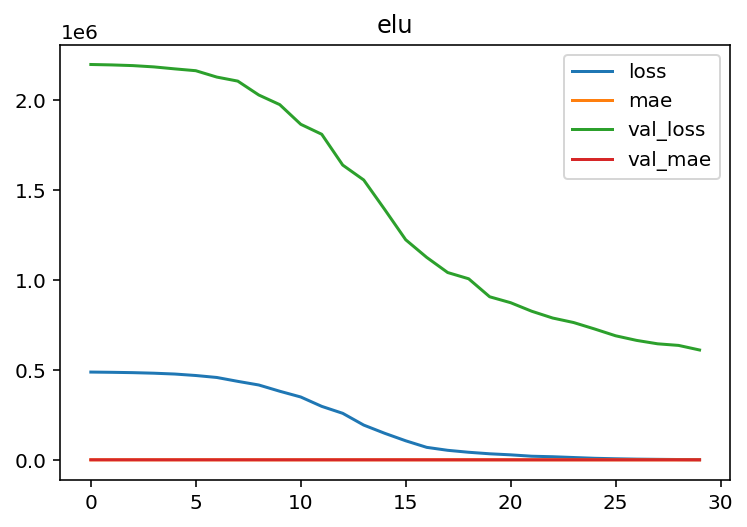

In [51]:
for activation in activations:
    model = make_model(activation) # создаем модель
    history = model.fit(x_train_scl, 
                        y_train, 
                        epochs=30, 
                        batch_size=32, 
                        validation_split=0.2,
                        callbacks=keras.callbacks.EarlyStopping(patience=5),
                        verbose=0
                       ) # сохраняем историю тренировки
    pd.DataFrame(history.history).plot(title=activation) # визуализируем